In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from datasets.image_captioning import *

from utils import load_checkpoint
from models.captioning import CaptionNet

import config

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import os

from models.compress import HyperpriorWrapper, bmshj2018_hyperprior

%matplotlib inline

/home/vvh413/Documents/dev/compression/datasets/image_captioning/dataset.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  captions = np.array(captions)


In [2]:
network = CaptionNet(n_tokens, cnn_feature_size=12288).to(config.DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=1e-4)

In [3]:
load_checkpoint("captions_compressed_8.pth.tar", network, optimizer, 1e-3)

=> Loading checkpoint


In [4]:
# from models.beheaded_inception3 import beheaded_inception_v3
# inception = beheaded_inception_v3().train(False)

In [5]:
compressor = HyperpriorWrapper(
    bmshj2018_hyperprior(config.COMPRESS_QUALITY, pretrained=True)
    .eval()
    .to(config.DEVICE),
    type="s",
)

In [6]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
  
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        # vectors_8x8, vectors_neck, logits = inception(image[None])
        vectors_neck = compressor.compress(image[None])
        vectors_neck = F.avg_pool2d(vectors_neck, kernel_size=2)
        vectors_neck = torch.flatten(vectors_neck, start_dim=1)
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck.to(config.DEVICE), prefix_ix.to(config.DEVICE))[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.detach().cpu().numpy()
            next_word_probs = next_word_probs.clip(0)
            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature
            
            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

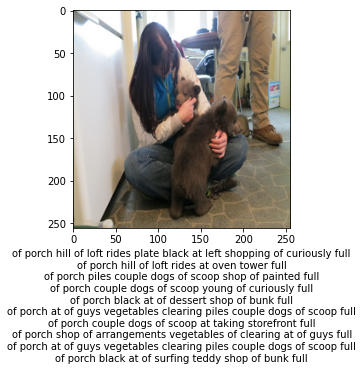

In [17]:
#sample image
# path = 'datasets/image_captioning/flickr30k_images/flickr30k_images/'
path = "datasets/image_captioning/coco2017/"
image = random.choice(os.listdir(path))
img = plt.imread(os.path.join(path, image))
img = Image.fromarray(img).resize((256, 256))
img = np.array(img).astype('float32') / 255.0

txt = ""
for i in range(10):
    txt += ' '.join(generate_caption(img, t=5.)[1:-1]) + "\n"
plt.xlabel(txt)
plt.imshow(img)